# Splash dynamics on a cone surface



## Documentation and Imports


Created on 27-07-21

Author: Valentin Laplaud

Formulas and graphs describing the dynamics of a drop splashing on a cone

In [1]:
# plotting stuff
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline

COLOR = 'white'
COLOR2 = 'black'

mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

mpl.rcParams["figure.facecolor"] = COLOR2
mpl.rcParams["axes.facecolor"] = COLOR2
mpl.rcParams["savefig.facecolor"] = COLOR2

import matplotlib.pyplot as plt
from cycler import cycler


# numbers handling
import numpy as np
from numpy import pi
import pandas as pd

# signal processing 
from scipy.signal import savgol_filter, correlate, correlation_lags
from scipy.interpolate import interp1d


# to hide known warnings
import warnings
warnings.filterwarnings("ignore")

# General system functions
import os
import shutil
import sys

import time

# my functions
sys.path.append('../PythonFuncs/')
import VallapFunc_DP as vf


## Analytical model

###  Cone geometry

In [2]:
        """ For a specific cone, of diameter Rc and angle Alpha with the vertical, we compute :
        the radius Ro of the original circle, 
        the angle Beta of the sector removed from the circle, 
        the fraction Fr of circle surface in the cone"""

        def coneGeometry(Rcone,Alpha):
            # perimeter of cone 
            Pcone = 2*pi*Rcone # (in mm)

            # Cone Side length
            Lcone = Rcone/np.sin(Alpha)

            """ Unfolded cone as a cropped circle of radius Lcone """

            Rcircle = Lcone.copy()

            # Perimter of full circle
            Pcircle = 2*pi*Rcircle

            # Fraction of the circle remaining to form the cone
            Fr = Pcone/Pcircle # analytically Fr = sin(Alpha)

            # Angle of the removed circle part
            Beta = 2*pi*(1-Fr) # analytically Beta = 2*pi*(1-sin(Alpha))

            return(Rcircle,Beta,Fr)

### Drop impact characteristics

#### Adimensional numbers

In [3]:
### Parameters
V = 4 # [m/s] drop impact speed
L = 0.003 # [m] cone diameter
rho = 1000 # [kg/m3] water density
mu = 0.001 # [Pa.s] water viscosity
gamma = 0.07 # [N/m] water surface tension
g = 9.8 # [m/s²] gravity constant

### Adimensional numbers

# Reynolds (viscosity vs. intertia)
Re = rho*V*L/mu
print('Reynolds = ' + str(Re))

# Weber (capilarity vs. inertia)
We = rho*L*V**2/gamma
print('Weber = ' + str(We))

# Froude (gravity vs. intertia)
Fr = V/np.sqrt(g*L)
print('Froude = ' + str(Fr))

Reynolds = 12000.0
Weber = 685.7142857142857
Froude = 23.328473740792173


#### Localisation of points in drop and on cone

In [4]:
def PointsInSplash(R,Theta,Rc,Rd,Xd,Yd):
    # Points to evaluate in radial coord (R,Theta), Cone radius, Drop radius, drop center (Xd,Yd) 
    
    # For a set of points, returns a boolean vector telling if they are at the intersection of 
    # the cone and the drop, and thus in the splash
    
    ## Point in the cone 
    isInCone = R<Rc
    
    ## Point in the drop
    isInDrop = R**2 - 2*R*(Xd*np.cos(Theta)+Yd*np.sin(Theta)) + Xd**2 + Yd**2 < Rd**2
    
    return(isInCone,isInDrop)

#### Fall proba and volume fractions

##### Probability of the drop of radius Rd to fall at a distance r from the center of the cone of radius Rc

In [5]:

""" We consider the probability of falling in a stripe of width dr = 1% of Rc+Rd. 
The center of the drop can fall short of the cone but still have a partial splash""" 

# P(r) = 2*pi*r*dr / pi*(Rc+Rd)²  with dr = 1/100*(Rc+Rd)  thus P(r) = 2*r/(100*(Rc+Rd)) = r/(50*(Rc+Rd))

def Proba(r,Rd,Rc):
    P =  r/50/(Rc+Rd)*100 # in %
    return(P)




##### Fraction of the drop volume impacting the cone

In [6]:
""" Fraction of the drop volume impacting the cone for a impact at distance r from the center """

## The computation is done using the formula for the intersection of a sphere and a cylinder 

def volFrac(r,Rd,Rc):
    F = np.empty(len(r))
    for rr,ir in zip(r,range(len(r))):
        if rr+Rd<=Rc:
            F[ir] = 1
        else:                
            F[ir] = vf.interVolSC(Rd,Rc,rr)/(4/3*pi*Rd**3)
    return(F*100)


##### Fraction of splash/drop in the jet -> This analytic idea doesn't work see PPT

In [7]:
""" Fraction of the impacting volume forming the jet (for r > Rcircle)"""

# The impact point (I) of the drop is along the bisecant of the removed sector, 
# at a distance r of the center of the circle (C).
# For certain angles, a straight trajectory originating in (I), with an angle Gamma, can intersect the 
# border of the removed sector at a point (M). (M) is at a distance rM < Rcircle from the center (C). 
# For a point (M) at rM = Rcircle, the angle GammaMax defines the fraction of the splash that ends up 
# in the jet

def splashFracJet(r,Rcone,Rdrop,Alpha): # returns the fraction of a splash in the jet, for an impact at distance r, 
    # on a cone of angle Alpha and radius Rcone
    
    Rcircle,Beta = coneGeometry(Rcone,Alpha)[0:2]
    
    FJ = np.empty(len(r))
    for rr,ir in zip(r,range(len(r))):
    
        if rr>Rcone:
            
            jetAngle = 2*np.arctan((np.sin(Beta/2)*Rcircle)/(rr+np.cos(Beta/2)*Rcircle)) 
            # Angle between the border of the removed sector and the drop center, 
            # corresponds to the part of the splash ending up in the jet



            splashAngle = 2*np.arctan2(Rcone*np.sin(np.sin(Alpha)*np.arccos((Rdrop**2-Rcone**2-rr**2)/(2*rr*Rcone))),
                                      rr-Rcone*np.cos(np.sin(Alpha)*np.arccos((Rdrop**2-Rcone**2-rr**2)/(2*rr*Rcone))))
            # angle between the interection points of drop and cone, defining the angle of the jet

            FJ[ir] = np.min([jetAngle/splashAngle, 1])
        
        else:
            """"Needs to be done if there is a geometrical solution """""
    return(FJ*100)


""" Drop volume fraction in the splash (for r > Rcircle)"""

def DropFrac(r,Rcone,Rdrop,Alpha):
    
    Fimpact = volFrac(r,Rdrop,Rcone)/100 # fraction of the drop to impact
    Fjet = splashFracJet(r,Rcone,Rdrop,Alpha)/100 # fraction of the impacting volume in the jet
    
    
    DF = Fimpact*Fjet
    
    return(DF*100)

##### Numerical resolution of fraction of volume in the jet

###### In 2D

In [8]:
def JetVolFrac2D(coneR,Alpha,dropR,Xdrops,nptmesh):
    # computes the fraction of the volume impacting the cone ending up in the jet 
    # as a function of the cone radius and vertical angle Alpha, of the drop radius and position 
    # and of the distance r between cone and drop center. 
    # The number of point along one side of the mesh is a parameter

    # We consider a cone centered on (0,0) and a drop with center in position (Xdrop,0), 
    # Xdrop corresponds to the distance between the centers

    # Fraction of splash in jet
    Frac = np.empty(len(Xdrops))

    ### Cone in circle config
    circleR = coneGeometry(coneR,Alpha)[0] # Cropped circle radius
    Beta = coneGeometry(coneR,Alpha)[1] # angle of sector to remove

    for Xdrop,ir in zip(Xdrops,range(len(Xdrops))):

        ### Drop
        Ydrop = 0
        Adrop,Rdrop = vf.ToCirc(Xdrop,Ydrop,angle='rad') # Drop center (cone config) in radial 
        # centered on the cone
        XdCi,YdCi = vf.ToCart(Adrop,Rdrop/np.sin(Alpha)) # Drop center (circle config)
        AdCi,RdCi = vf.ToCirc(XdCi,YdCi,angle = 'rad') # Drop center in radial centered 
        # on the cone (circle config)

        ### Mesh of points in the splash
        Xmin, Xmax, Ymin, Ymax = (np.min([-coneR,Xdrop-dropR]),np.max([coneR,Xdrop+coneR]),
                                         np.min([-coneR,Ydrop-dropR]), np.max([coneR,Ydrop+coneR]))
        Xs = np.linspace(Xmin, Xmax, nptmesh)
        Ys = np.linspace(Ymin, Ymax, nptmesh)
        Xgrid,Ygrid = np.meshgrid(Xs,Ys) # mesh points in carthesian (cone config)
        Xgrid = Xgrid.flatten()
        Ygrid = Ygrid.flatten()
        Agrid,Rgrid = vf.ToCirc(Xgrid,Ygrid) # mesh points in polar (cone config)

        # points in the impacting volume (cone config)
        isCone,isDrop = PointsInSplash(Rgrid,Agrid,coneR,dropR,Xdrop,Ydrop) 
        Xsplash = Xgrid[isCone&isDrop]
        Ysplash = Ygrid[isCone&isDrop]
        Asplash, Rsplash = vf.ToCirc(Xsplash,Ysplash, angle = 'rad') 
        # circe config
        XsplashCi, YsplashCi = vf.ToCart((Asplash-AdCi)*np.sin(Alpha)+AdCi,Rsplash/np.sin(Alpha),angle='rad')

        ### Geometry of the removed sector to form a cone        
        T1 = np.mod(-Beta/2,2*pi)
        T2 = np.mod(Beta/2,2*pi)
        if T1>T2:
            Ts = np.linspace(np.mod(T1+pi,2*pi),np.mod(T2+pi,2*pi),20) - pi        
        else:                
            Ts = np.linspace(T1,T2,20)


        ### Trajectories of each point and sector crossing
        pts = np.linspace(0,3,5)
        Xpts = np.empty((len(pts),len(XsplashCi)))
        Ypts = np.empty((len(pts),len(YsplashCi)))
        inter = np.empty(len(YsplashCi))
        Xint = np.empty((len(pts),len(XsplashCi)))
        Yint = np.empty((len(pts),len(YsplashCi)))
        # equations for the lines of the sector borders (y = c12*x)
        c1 = np.tan(Adrop+pi-Beta/2)
        c2 = np.tan(Adrop-pi+Beta/2)
        for (x,y,i) in zip(XsplashCi, YsplashCi, range(len(XsplashCi))):
            Xpts[:,i] = x + pts*(x-XdCi)/np.sqrt(vf.dist(x,y,XdCi,YdCi))
            Ypts[:,i] = y + pts*(y-YdCi)/np.sqrt(vf.dist(x,y,XdCi,YdCi))
            # equation for the line along the trajectory (y = a*x + b)
            a = (Ypts[1,i] - YdCi)/(Xpts[1,i] - XdCi)
            b = (Xpts[1,i]*YdCi - Ypts[1,i]*XdCi)/(Xpts[1,i] - XdCi) 
            # intersection points
            xi1 = b/(c1-a)
            xi2 = b/(c2-a)
            Xint[:,i] = xi1
            Yint[:,i] = c1*xi1
            # intersection if Ri1 or Ri2 is >0 and <Rcircle
            inter[i] = (((xi1/np.cos(Adrop+pi-Beta/2)>=0)&(xi1/np.cos(Adrop+pi-Beta/2)<circleR)&(Xpts[1,i]<XdCi)) | 
                        ((xi2/np.cos(Adrop-pi+Beta/2)>=0)&(xi2/np.cos(Adrop-pi+Beta/2)<circleR)&(Xpts[1,i]<XdCi)))

        Frac[ir] = np.sum(inter)/len(inter)

    return(Frac*100)

###### Sphere height

In [9]:
def SphereH(R,X,Y,Xs):
    # Compute the height of a column at (X,Y) in a sphere of radius R centered on (Xs,0,0)
    
    H = 2*np.sqrt(R**2-(X-Xs)**2-Y**2)
    
    H[np.isnan(H)] = 0
    
    return(H)

###### In 3D

In [10]:
def JetVolFrac3D(coneR,Alpha,dropR,Xdrops,nptmesh):
    # computes the fraction of the volume impacting the cone ending up in the jet 
    # as a function of the cone radius and vertical angle Alpha, of the drop radius and position 
    # and of the distance r between cone and drop center. 
    # The number of point along one side of the mesh is a parameter

    # We consider a cone centered on (0,0) and a drop with center in position (Xdrop,0), 
    # Xdrop corresponds to the distance between the centers

    # Fraction of splash in jet
    Frac = np.empty(len(Xdrops))

    ### Cone in circle config
    circleR = coneGeometry(coneR,Alpha)[0] # Cropped circle radius
    Beta = coneGeometry(coneR,Alpha)[1] # angle of sector to remove

    for Xdrop,ir in zip(Xdrops,range(len(Xdrops))):

        ### Drop
        Ydrop = 0
        Adrop,Rdrop = vf.ToCirc(Xdrop,Ydrop,angle='rad') # Drop center (cone config) in radial 
        # centered on the cone
        XdCi,YdCi = vf.ToCart(Adrop,Rdrop/np.sin(Alpha)) # Drop center (circle config)
        AdCi,RdCi = vf.ToCirc(XdCi,YdCi,angle = 'rad') # Drop center in radial centered 
        # on the cone (circle config)

        ### Mesh of points in the splash
        Xmin, Xmax, Ymin, Ymax = (np.min([-coneR,Xdrop-dropR]),np.max([coneR,Xdrop+coneR]),
                                         np.min([-coneR,Ydrop-dropR]), np.max([coneR,Ydrop+coneR]))
        Xs = np.linspace(Xmin, Xmax, nptmesh)
        Ys = np.linspace(Ymin, Ymax, nptmesh)
        Xgrid,Ygrid = np.meshgrid(Xs,Ys) # mesh points in carthesian (cone config)
        Xgrid = Xgrid.flatten()
        Ygrid = Ygrid.flatten()
        Agrid,Rgrid = vf.ToCirc(Xgrid,Ygrid) # mesh points in polar (cone config)

        # points in the impacting volume (cone config)
        isCone,isDrop = PointsInSplash(Rgrid,Agrid,coneR,dropR,Xdrop,Ydrop) 
        Xsplash = Xgrid[isCone&isDrop]
        Ysplash = Ygrid[isCone&isDrop]
        Hsplash = SphereH(dropR,Xsplash,Ysplash,Xdrop)
        Asplash, Rsplash = vf.ToCirc(Xsplash,Ysplash, angle = 'rad') 
        # circe config
        XsplashCi, YsplashCi = vf.ToCart((Asplash-AdCi)*np.sin(Alpha)+AdCi,Rsplash/np.sin(Alpha),angle='rad')

        ### Geometry of the removed sector to form a cone        
        T1 = np.mod(-Beta/2,2*pi)
        T2 = np.mod(Beta/2,2*pi)
        if T1>T2:
            Ts = np.linspace(np.mod(T1+pi,2*pi),np.mod(T2+pi,2*pi),20) - pi        
        else:                
            Ts = np.linspace(T1,T2,20)


        ### Trajectories of each point and sector crossing
        pts = np.linspace(0,3,5)
        Xpts = np.empty((len(pts),len(XsplashCi)))
        Ypts = np.empty((len(pts),len(YsplashCi)))
        inter = np.empty(len(YsplashCi))
        Xint = np.empty((len(pts),len(XsplashCi)))
        Yint = np.empty((len(pts),len(YsplashCi)))
        # equations for the lines of the sector borders (y = c12*x)
        c1 = np.tan(Adrop+pi-Beta/2)
        c2 = np.tan(Adrop-pi+Beta/2)
        for (x,y,i) in zip(XsplashCi, YsplashCi, range(len(XsplashCi))):
            Xpts[:,i] = x + pts*(x-XdCi)/np.sqrt(vf.dist(x,y,XdCi,YdCi))
            Ypts[:,i] = y + pts*(y-YdCi)/np.sqrt(vf.dist(x,y,XdCi,YdCi))
            # equation for the line along the trajectory (y = a*x + b)
            a = (Ypts[1,i] - YdCi)/(Xpts[1,i] - XdCi)
            b = (Xpts[1,i]*YdCi - Ypts[1,i]*XdCi)/(Xpts[1,i] - XdCi) 
            # intersection points
            xi1 = b/(c1-a)
            xi2 = b/(c2-a)
            Xint[:,i] = xi1
            Yint[:,i] = c1*xi1
            # intersection if Ri1 or Ri2 is >0 and <Rcircle
            inter[i] = (((xi1/np.cos(Adrop+pi-Beta/2)>=0)&(xi1/np.cos(Adrop+pi-Beta/2)<circleR)&(Xpts[1,i]<XdCi)) | 
                        ((xi2/np.cos(Adrop-pi+Beta/2)>=0)&(xi2/np.cos(Adrop-pi+Beta/2)<circleR)&(Xpts[1,i]<XdCi)))

        Frac[ir] = np.sum(Hsplash[inter.astype(bool)])/np.sum(Hsplash)
    return(Frac*100)

### Trajectories transformation

In [11]:

def makeTraj(Xo,Yo,angles,npts,Xc,Yc,Rc,length,IsIn):
    # Radial trajectories from the point (X0,Y0). The length of 'angles' defines the number of trajectories and 
    # their radial positions. 'length' is the lenght of the trajectory in terms of Rc units
    # IsIn is a boolean for selecting only the trajectory points inside the circle of center (Xc,Yc) and radius Rc
    
    
    X = []
    Y = []
    T = []

    for a in angles:
        X = np.append(X,Xo + np.linspace(0,length*Rc,npts)*np.cos(a))
        Y = np.append(Y,Yo + np.linspace(0,length*Rc,npts)*np.sin(a))
        T = np.append(T,np.linspace(0,10,npts))
    
    if IsIn:
        insidePts = vf.dist(X,Y,Xc,Yc) < Rc

        X = X[insidePts]
        Y = Y[insidePts]
        T = T[insidePts]
    

    
    return(X,Y,T)

def Cone2Circle(X,Y,Alpha,Ad):
    # (X,Y) points to transform, Alpha angle of the cone, Ad angle of the drop center position (cone config)
    A,R = vf.ToCirc(X,Y,angle = 'rad')
    Xnew,Ynew = vf.ToCart((A-Ad)*np.sin(Alpha)+Ad,R/np.sin(Alpha),angle = 'rad')

    return(Xnew,Ynew)

def Circle2Cone(X,Y,Alpha,Ad): 
    # (X,Y) points to transform, Alpha angle of the cone, Ad angle of the drop center position (circle config)
    A,R = vf.ToCirc(X,Y,angle = 'rad')
    Xnew,Ynew = vf.ToCart((A-Ad)/np.sin(Alpha)+Ad,R*np.sin(Alpha),angle = 'rad')
    
    return(Xnew,Ynew)

def ComputeTransfo(Xc,Yc,Rcircle,Alpha,Xi,Yi,angles, **kwargs):
    # Circle center (Xc,Yc) & radius (Rcircle), cone angle (Alpha), impact coordinates (Xi,Yi),
    # points to transform (X,Y) 

        Animation = False
        P = ''
        Tt = ''
        Return = 'Figure'
        
        for key, value in kwargs.items(): 
            if key == 'animation':
                Animation = value  
            elif key == 'path':
                P = value  
            elif key == 'title':
                Tt = value   
            elif key == 'return':
                Return = value  
            else:
                print('Unknown key : ' + key + '. Kwarg ignored.')

        if (Animation) & (P==''):
            print('If Animation = True, kwarg "path" must have a value')
            return

        if (Animation) & (Tt==''):
            print('If Animation = True, kwarg "title" must have a value')
            return
            
        X,Y = makeTraj(Xi,Yi,angles,125,Xc,Yc,Rcircle, 5, True)    
            
        Rcone = Rcircle*np.sin(Alpha) # cone radius
        Beta = coneGeometry(Rcone,Alpha)[1] # angle of sector to remove
        Fr = coneGeometry(Rcone,Alpha)[2] # fraction of circle remaining to form the cone

        """ Alignement on (0,0) """

        alXi = Xi - Xc
        alYi = Yi - Yc

        alX = X - Xc
        alY = Y - Yc
                
        OffA = vf.ToCirc(Xc-Xi,Yc-Yi,angle = 'rad')[0] #angle between impact and center

        """ Conversion to circular coordinates """

        Ti,Ri =  vf.ToCirc(alXi,alYi,angle='rad')

        T,R =  vf.ToCirc(alX,alY,angle='rad')
        T = np.mod(T,2*pi)
        
        """ Removed sector to form a cone """
        
        T1 = np.mod(OffA - Beta/2,2*pi)
        T2 = np.mod(OffA + Beta/2,2*pi)

     
        if T1>T2:
            Ts = np.linspace(np.mod(T1+pi,2*pi),np.mod(T2+pi,2*pi),20) - pi
            goodPts = ((T < T1) & (T > T2))            
        else:                
            Ts = np.linspace(T1,T2,20)
            goodPts = ((T < T1) | (T > T2))
            
        alX,alY = vf.ToCart(T[goodPts],R[goodPts],angle='rad') 
                
        sectorT = np.append(np.append([T1],Ts),[T2])
        sectorR = np.append(np.append([0],Rcircle*np.ones(20)),[0])
        
        sectorX,sectorY = vf.ToCart(sectorT,sectorR,angle = 'rad')
        
        # Impact point
        coneTi = Ti
        coneRi = Ri*Fr
        
        coneXi,coneYi = vf.ToCart(coneTi,coneRi,angle='rad')
        coneZi = coneRi*np.cos(Alpha)
        
        # Trajectories
        
        coneT = np.mod(T[goodPts]-Ti,2*pi)
        coneT[coneT>pi] = coneT[coneT>pi]-2*pi
        coneT = coneT/Fr + Ti
        
        coneR = R[goodPts]*Fr
        coneZ = coneR*np.cos(Alpha)
        
        coneX,coneY = vf.ToCart(coneT,coneR,angle='rad')
        
        """ Transformation from circle to cone """
        
        if Animation:
            """ Circle to cone animation """            
            
            for i in range(0,101):
                fig0= plt.figure(dpi = 500)
                fig0.suptitle(Tt)                
                
                ax01 = fig0.add_subplot(1,2,2) 
                ax02 = fig0.add_subplot(1,2,1,projection='3d')                
                
                ax01.set_aspect('equal', adjustable='box')
                ax01.set_xlim([-Rcircle*1.1, Rcircle*1.1] )
                ax01.set_ylim([-Rcircle*1.1, Rcircle*1.1])
                ax01.set_xticks([])
                ax01.set_yticks([])
                ax01.set_title('Cone projection on (X,Y) plane')
                
                ax02.set_xticks([])
                ax02.set_yticks([])
                ax02.set_zticks([])
                ax02.set_xlim([-Rcircle*1.1, Rcircle*1.1])
                ax02.set_ylim([-Rcircle*1.1, Rcircle*1.1])
                ax02.set_zlim([0, Rcircle*np.cos(Alpha)])
                ax02.set_title('Cone folding in 3D')
                
                coneTi = Ti
                coneRi = Ri*(1-(1-Fr)*i/100)

                coneXi,coneYi = vf.ToCart(coneTi,coneRi,angle='rad')
                coneZi = coneRi*np.cos(Alpha)*i/100

                # Trajectories
                        

                coneT = np.mod(T[goodPts]-Ti,2*pi)
                coneT[coneT>pi] = coneT[coneT>pi]-2*pi
                coneT = coneT/(1-(1-Fr)*i/100) + Ti

                coneR = R[goodPts]*(1-(1-Fr)*i/100)
                coneZ = coneR*np.cos(Alpha)*i/100

                coneX,coneY = vf.ToCart(coneT,coneR,angle='rad')
            
                tx = np.linspace(0,2*pi,1000)
                
                Rcircle*(1-(1-Fr)*i/100)*np.cos(tx),Rcone*np.cos(Alpha)*i/100
            
                circleX = Rcircle*(1-(1-Fr)*i/100)*np.cos(tx)
                circleY = Rcircle*(1-(1-Fr)*i/100)*np.sin(tx)
                circleZ = np.max(coneZ)*np.ones(len(circleX))
                
                
                T1 = np.mod(OffA - Beta/2*(100-i)/100,2*pi)
                T2 = np.mod(OffA + Beta/2*(100-i)/100,2*pi)
                
                if T1>T2:
                    Ts = np.linspace(np.mod(T1+pi,2*pi),np.mod(T2+pi,2*pi),20) - pi
                            
                else:                
                    Ts = np.linspace(T1,T2,20)
            
                sectorT = np.append(np.append([T1],Ts),[T2])
                sectorR = np.append(np.append([0],Rcircle*(1-(1-Fr)*i/100*np.ones(len(Ts)))),[0])
                sectorZ = sectorR*np.cos(Alpha)*i/100
                
                sectorX,sectorY = vf.ToCart(sectorT,sectorR,angle='rad')
            
                ax01.plot(coneX,coneY,'c.',ms=0.5)
                ax01.plot(coneXi,coneYi,'xr',ms = 2)
                ax01.plot(circleX,circleY,'go',ms=1.5)
                ax01.plot(sectorX,sectorY,'m--',lw=1)
                ax01.plot(0,0,'g*')
                
                ax02.plot3D(coneXi,coneYi,coneZi,'xr',ms = 2)
                ax02.plot3D(coneX,coneY,coneZ,'c.',ms=0.5)
                ax02.plot3D(circleX,circleY,circleZ,'go',ms=1.5)
                ax02.plot3D(sectorX,sectorY,sectorZ,'m--',lw=1)
                ax02.plot3D(0,0,0,'g*')
                
                fig0.tight_layout()
                fig0.savefig(P + str(i) + '.tif' )
                plt.close()
        if Return == 'Figure':
            return(fig,[ax1,ax2,ax3,ax4])
        elif Return == 'Data':
            return(alX,alY,alXi,alYi,sectorX,sectorY,Rcircle,OffA,Rcone,coneX,coneY,coneXi,coneYi)
        else:
            return

## Plots

In [12]:
savepath = r'D:\Users\laplaud\Desktop\PostDoc\Data\SplashCups\Model\Images'

### Numerical values & Plots 

#### Representations

##### Parameters

In [13]:
tx = np.linspace(0,2*pi,500)

### Cone
Xc = 0 # Cone center X always 0
Yc = 0 # Cone center Y always 0
coneR = 4 # Cone radius
Alpha = pi/4 # Cone vertical angle
circleR = coneGeometry(coneR,Alpha)[0] # Cropped circle radius
Beta = coneGeometry(coneR,Alpha)[1] # angle of sector to remove

### Drop
Xdrop = 3 # Drop center X (in cone configuration)
Ydrop = 0 # Drop denter Y (in cone configuration)
dropR = 4 # Drop radius (cone config)

##### Analytical circle transformation

In [14]:

# Xdrops = Xdrop + dropR*np.cos(tx) # Drawing drop in cone config (X)
# Ydrops = Ydrop + dropR*np.sin(tx) # Drawing drop in cone config (Y)
# Adrop,Rdrop = vf.ToCirc(Xdrop,Ydrop,angle='rad') # Drop center (cone config) in radial 
# # centered on the cone
# Adrops, Rdrops = vf.ToCirc(Xdrops,Ydrops,angle='rad') # Drop drawing (cone config) in radial 
# # centered on the cone
# XdCi,YdCi = vf.ToCart(Adrop,Rdrop/np.sin(Alpha)) # Drop center (circle config)
# XdCi = XdCi # Recentering X drop (circle config) in carthesian
# YdCi = YdCi # Recentering Y drop (circle config) in carthesian
# AdCi,RdCi = vf.ToCirc(XdCi,YdCi,angle = 'rad') # Drop center in radial centered 
# # on the cone (circle config)
# XdCis, YdCis = vf.ToCart((Adrops-AdCi)*np.sin(Alpha)+AdCi,Rdrops/np.sin(Alpha),angle='rad') # drop drawing 
# # (circle config) in carthesian

# ### Removed sector to form a cone 
        
# T1 = np.pi-Beta/2
# T2 = np.pi+Beta/2

# if T1>T2:
#     Ts = np.linspace(np.mod(T1+pi,2*pi),np.mod(T2+pi,2*pi),20) - pi        
# else:                
#     Ts = np.linspace(T1,T2,20)

# sectorT = np.append(np.append([T1],Ts),[T2])
# sectorR = np.append(np.append([0],circleR*np.ones(20)),[0])

# sectorX,sectorY = vf.ToCart(sectorT,sectorR,angle = 'rad')

# ### Anaytical drop equation in circle config

# if Xdrop > dropR:
#     ThetaBorder = np.sin(Alpha)*np.arcsin(dropR/Xdrop)
#     Theta = np.linspace(-ThetaBorder,ThetaBorder,200)
#     R1 = (Xdrop*np.cos(np.divide(Theta,np.sin(Alpha))) - np.sqrt(dropR**2-Xdrop**2*np.sin(np.divide(Theta,np.sin(Alpha)))**2))/(np.sin(Alpha))
#     R2 = (Xdrop*np.cos(np.divide(Theta,np.sin(Alpha))) + np.sqrt(dropR**2-Xdrop**2*np.sin(np.divide(Theta,np.sin(Alpha)))**2))/(np.sin(Alpha))
#     Theta = np.concatenate((Theta, np.flip(Theta)))
#     R = np.concatenate((R1, R2))
# else:
#     ThetaBorder = np.pi - Beta/2
#     Theta = np.linspace(-ThetaBorder,ThetaBorder,200)
#     R = (Xdrop*np.cos(np.divide(Theta,np.sin(Alpha))) + np.sqrt(dropR**2-Xdrop**2*np.sin(np.divide(Theta,np.sin(Alpha)))**2))/(np.sin(Alpha))


# X,Y = vf.ToCart(Theta,R, angle = 'rad')


# fig1, [ax11,ax12] = plt.subplots(ncols=2, dpi = 500)
# fig1.suptitle("Analytical definition of drop transformation")

# ax11.set_xticks([])
# ax11.set_yticks([])
# ax11.plot(coneR*np.cos(tx),coneR*np.sin(tx),'g-',lw=1);
# ax11.plot(Xdrop + dropR*np.cos(tx), Ydrop + dropR*np.sin(tx), 'c-', lw = 1)
# ax11.plot(Xdrops,Ydrops,'ro',ms=1);
# ax11.plot(Xdrop,Ydrop,'r*',ms = 1.5);
# ax11.plot(0,0,'g*',ms = 1.5);
# ax11.set_aspect('equal')
# ax11.set_title('Cone config');

# ax12.set_xticks([])
# ax12.set_yticks([])
# ax12.plot(0,0,'g*',ms = 1.5);
# ax12.plot(circleR*np.cos(tx),circleR*np.sin(tx),'g-',lw=1);
# ax12.plot(sectorX,sectorY,'--m',lw=1)
# ax12.plot(X,Y, 'c-', lw = 1)
# ax12.plot(XdCi,YdCi,'ro',ms=1);
# ax12.plot(XdCis,YdCis,'r*',ms = 5);
# ax12.set_aspect('equal')
# ax12.set_title('Circle config');


##### Plots of probability and transformation illustration

In [15]:
# tx = np.linspace(0,2*pi,200)

# ### Cone
# Xc = 0 # Cone center X always 0
# Yc = 0 # Cone center Y always 0
# coneR = 4 # Cone radius
# Alpha = pi/4 # Cone vertical angle
# circleR = coneGeometry(coneR,Alpha)[0] # Cropped circle radius
# Beta = coneGeometry(coneR,Alpha)[1] # angle of sector to remove

# ### Drop
# Xdrop = 5 # Drop center X (in cone configuration)
# Ydrop = 0 # Drop denter Y (in cone configuration)
# dropR = 3 # Drop radius (cone config)
# Xdrops = Xdrop + dropR*np.cos(tx) # Drawing drop in cone config (X)
# Ydrops = Ydrop + dropR*np.sin(tx) # Drawing drop in cone config (Y)
# Adrop,Rdrop = vf.ToCirc(Xdrop,Ydrop,angle='rad') # Drop center (cone config) in radial 
# # centered on the cone
# Adrops, Rdrops = vf.ToCirc(Xdrops,Ydrops,angle='rad') # Drop drawing (cone config) in radial 
# # centered on the cone
# XdCi,YdCi = vf.ToCart(Adrop,Rdrop/np.sin(Alpha)) # Drop center (circle config)
# XdCi = XdCi # Recentering X drop (circle config) in carthesian
# YdCi = YdCi # Recentering Y drop (circle config) in carthesian
# AdCi,RdCi = vf.ToCirc(XdCi,YdCi,angle = 'rad') # Drop center in radial centered 
# # on the cone (circle config)
# XdCis, YdCis = vf.ToCart((Adrops-AdCi)*np.sin(Alpha)+AdCi,Rdrops/np.sin(Alpha),angle='rad') # drop drawing 
# # (circle config) in carthesian


# ### Drop-Cone distance
# rstep = (coneR+dropR)/98
# nstep = int(np.ceil((coneR+dropR)/rstep))
# r = np.linspace(rstep/2,coneR+dropR-3*rstep/2,nstep) # impact position
# Pr = Proba(r,dropR,coneR)


# ### Mesh of points in the splash
# nptmesh = 250
# Xmin, Xmax, Ymin, Ymax = (np.min([-coneR,Xdrop-dropR]),np.max([coneR,Xdrop+coneR]),
#                                  np.min([-coneR,Ydrop-dropR]), np.max([coneR,Ydrop+coneR]))
# Xs = np.linspace(Xmin, Xmax, nptmesh)
# Ys = np.linspace(Ymin, Ymax, nptmesh)
# Xgrid,Ygrid = np.meshgrid(Xs,Ys)

# Xgrid = Xgrid.flatten()
# Ygrid = Ygrid.flatten()

# Agrid,Rgrid = vf.ToCirc(Xgrid,Ygrid)

# isCone,isDrop = PointsInSplash(Rgrid,Agrid,coneR,dropR,Xdrop,Ydrop)

# Xsplash = Xgrid[isCone&isDrop] # in cone config
# Ysplash = Ygrid[isCone&isDrop] # in cone config
# Hsplash = SphereH(dropR,Xsplash,Ysplash,Xdrop)
# Asplash, Rsplash = vf.ToCirc(Xsplash,Ysplash, angle = 'rad')

# XsplashCi, YsplashCi = vf.ToCart((Asplash-AdCi)*np.sin(Alpha)+AdCi,Rsplash/np.sin(Alpha),angle='rad')

# ### Removed sector to form a cone        
# OffA = vf.ToCirc(Xc-XdCi,Yc-YdCi,angle = 'rad')[0] #angle between impact and center

# T1 = np.mod(OffA - Beta/2,2*pi)
# T2 = np.mod(OffA + Beta/2,2*pi)

# if T1>T2:
#     Ts = np.linspace(np.mod(T1+pi,2*pi),np.mod(T2+pi,2*pi),20) - pi        
# else:                
#     Ts = np.linspace(T1,T2,20)

# sectorT = np.append(np.append([T1],Ts),[T2])
# sectorR = np.append(np.append([0],circleR*np.ones(20)),[0])
# sectorX,sectorY = vf.ToCart(sectorT,sectorR,angle = 'rad')

# ### Trajectories of each point and sector crossing
# pts = np.linspace(0,3,5)
# Xpts = np.empty((len(pts),len(XsplashCi)))
# Ypts = np.empty((len(pts),len(YsplashCi)))
# inter = np.empty(len(YsplashCi))
# Xint = np.empty((len(pts),len(XsplashCi)))
# Yint = np.empty((len(pts),len(YsplashCi)))
# # equations for the lines of the sector borders (y = c12*x)
# c1 = np.tan(Adrop+pi-Beta/2)
# c2 = np.tan(Adrop-pi+Beta/2)
# for (x,y,i) in zip(XsplashCi, YsplashCi, range(len(XsplashCi))):
#     Xpts[:,i] = x + pts*(x-XdCi)/np.sqrt(vf.dist(x,y,XdCi,YdCi))
#     Ypts[:,i] = y + pts*(y-YdCi)/np.sqrt(vf.dist(x,y,XdCi,YdCi))
#     # equation for the line along the trajectory (y = a*x + b)
#     a = (Ypts[1,i] - YdCi)/(Xpts[1,i] - XdCi)
#     b = (Xpts[1,i]*YdCi - Ypts[1,i]*XdCi)/(Xpts[1,i] - XdCi) 
#     # intersection points
#     xi1 = b/(c1-a)
#     xi2 = b/(c2-a)
#     Xint[:,i] = xi1
#     Yint[:,i] = c1*xi1
#     # intersection if Ri1 or Ri2 is >0 and <circleR
#     inter[i] = (((xi1/np.cos(Adrop+pi-Beta/2)>=0)&(xi1/np.cos(Adrop+pi-Beta/2)<circleR)&(Xpts[1,i]<XdCi)) | 
#                 ((xi2/np.cos(Adrop-pi+Beta/2)>=0)&(xi2/np.cos(Adrop-pi+Beta/2)<circleR)&(Xpts[1,i]<XdCi)))


# import matplotlib.colors as colors

# def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
#     new_cmap = colors.LinearSegmentedColormap.from_list(
#         'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
#         cmap(np.linspace(minval, maxval, n)))
#     return new_cmap


# cmap = plt.get_cmap('Blues')
# bluemap = truncate_colormap(cmap,0.5,1,100)
    
# inter = inter.astype(bool)

# # probability of falling at a certain distance of the cone center
# fig10,ax10 = plt.subplots(dpi = 500)
# fig10.suptitle("Probability of falling at a distance 'r' from the center \n dropR = " + str(dropR) + " mm, coneR = " + str(coneR) + " mm. ")
# ax10.plot(r/(coneR+dropR)*100,Pr,'o', ms = 1)
# ax10.set_xlabel(' r  [% of (coneR+dropR)]');
# ax10.set_ylabel('Probability [%]');
# fig10.tight_layout()

# fig11, ax11 = plt.subplots(dpi = 500)
# ax11.set_aspect('equal', adjustable='box')
# ax11.set_xlabel('X')
# ax11.set_ylabel('Y')
# fig11.suptitle("Probability of falling at a distance 'r' from the center \n dropR = " + str(dropR) + " mm, coneR = " + str(coneR) + " mm. ")

# xcircle = coneR*np.cos(np.linspace(0,2*pi,100))
# ycircle = coneR*np.sin(np.linspace(0,2*pi,100))
# xgrid = np.arange(-(coneR+dropR), coneR+dropR, 0.1)
# ygrid = np.arange(-(coneR+dropR), coneR+dropR, 0.1)
# xx, yy = np.meshgrid(xgrid, ygrid)
# mask = np.sqrt(xx**2+yy**2)<(coneR+dropR)
# z = Proba(np.sqrt(xx[mask]**2+yy[mask]**2),dropR,coneR)

# ax11.plot(xcircle,ycircle,'-w')
# sc11 = ax11.scatter(xx[mask],yy[mask],c=z,s=1,cmap='jet')
# fig11.colorbar(sc11, ax = ax11, label = 'proba (%)',shrink = 0.6)


# fig5, ax5 = plt.subplots(dpi = 500)
# fig5.suptitle("Identification of points in \nthe splash and jet (cone config)")
# ax5.set_xticks([])
# ax5.set_yticks([])
# #ax5.plot(Xgrid[~isCone],Ygrid[~isCone],'or',ms=0.5)
# #ax5.plot(Xgrid[isCone&~isDrop],Ygrid[isCone&~isDrop],'og',ms=0.5)
# ax5.plot(Xsplash[~inter],Ysplash[~inter],'or',ms=0.3)
# ax5.scatter(Xsplash[inter],Ysplash[inter],c=Hsplash[inter],cmap=bluemap)
# #ax5.plot(Xgrid[~isCone&isDrop],Ygrid[~isCone&isDrop],'ob',ms=0.5)
# ax5.plot(coneR*np.cos(tx),coneR*np.sin(tx),'g-',lw=1);
# ax5.plot(Xdrops,Ydrops,'b.',ms=3);
# ax5.plot(Xdrop,Ydrop,'b*',ms = 1.5);
# ax5.plot(0,0,'g*',ms = 1.5);
# ax5.set_aspect('equal')

# fig6, ax6 = plt.subplots(dpi = 500)
# fig6.suptitle("Identification of points in \nthe splash and jet (circle config) ")
# ax6.set_xticks([])
# ax6.set_yticks([])
# ax6.plot(0,0,'g*', ms = 2);
# ax6.plot(circleR*np.cos(tx),circleR*np.sin(tx),'g-');
# ax6.plot(XdCi,YdCi,'b*',ms = 1);
# ax6.plot(XdCis,YdCis,'b.',ms=3);
# ax6.plot(sectorX,sectorY,'m--');
# ax6.set_aspect('equal')
# #ax6.plot(Xpts,Ypts,'co-',ms=0.3,lw= 0.4);
# #ax6.plot(XsplashCi[inter], YsplashCi[inter],'co',ms = 0.3);
# ax6.scatter(XsplashCi[inter],YsplashCi[inter],c=Hsplash[inter],cmap=bluemap)
# ax6.plot(XsplashCi[~inter], YsplashCi[~inter],'ro',ms = 0.3);



#### Simulations

In [16]:

# fig2,ax2 = plt.subplots(dpi = 500)
# fig2.suptitle("Fraction of drop volume impacting the cone\n dropR = " + str(dropR) + " mm, coneR = " + str(coneR) + " mm. ")
# ax2.plot(r/(coneR+dropR)*100,volFrac(r,dropR,coneR),'o', ms = 1)
# ax2.set_xlabel(' r  [% of (coneR+dropR)]');
# ax2.set_ylabel('Volume fraction [%]');

# JVFrac = JetVolFrac2D(coneR,Alpha,dropR,r,300)
# JVFrac3D = JetVolFrac3D(coneR,Alpha,dropR,r,300)
# DropVolFrac = volFrac(r,dropR,coneR)

# fig3,ax3 = plt.subplots(dpi = 500)
# fig3.suptitle("Fraction of impacting volume forming a jet\n dropR = " + str(dropR) + " mm, coneR = " + str(coneR) + " mm. ")
# ax3.plot(r/(coneR+dropR)*100,JVFrac,'ro',ms = 1,label='Simulation');
# #ax3.plot(r,JVFrac3D,'mo',ms = 1,label='Simulation 3D');
# ax3.plot(r[r>coneR]/(coneR+dropR)*100,splashFracJet(r[r>coneR],coneR,dropR,Alpha),'--',lw=1.5,label='Analytical solution');
# ax3.legend();
# ax3.set_xlabel(' r  [% of (coneR+dropR)]');
# ax3.set_ylabel('Volume fraction [%]');

# fig31,ax31 = plt.subplots(dpi = 500)
# fig31.suptitle("Fraction of impacting volume forming a jet\n dropR = " + str(dropR) + " mm, coneR = " + str(coneR) + " mm. ")
# ax31.plot(r/(coneR+dropR)*100,JVFrac,'ro',ms = 1,label='Simulation 2D');
# ax31.plot(r/(coneR+dropR)*100,JVFrac3D,'mo',ms = 1,label='Simulation 3D');
# ax31.plot(r[r>coneR]/(coneR+dropR)*100,splashFracJet(r[r>coneR],coneR,dropR,Alpha),'--',lw=1.5,label='Analytical solution');
# ax31.legend();
# ax31.set_xlabel(' r  [% of (coneR+dropR)]');
# ax31.set_ylabel('Volume fraction [%]');


# fig4,ax4 = plt.subplots(dpi = 500)
# fig4.suptitle("Drop volume fraction in the jet\n dropR = " + str(dropR) + " mm, coneR = " + str(coneR) + " mm. ")
# ax4.plot(r/(coneR+dropR)*100,volFrac(r,dropR,coneR)*JVFrac3D/100,'o',ms = 1)
# ax4.set_xlabel(' r  [% of (coneR+dropR)]');
# ax4.set_ylabel('Drop volume fraction in the jet [%]');


# fig41,ax41 = plt.subplots(dpi = 500)
# fig41.suptitle("Proba * Drop volume fraction in the jet\n dropR = " + str(dropR) + " mm, coneR = " + str(coneR) + " mm. ")
# ax41.plot(r/(coneR+dropR)*100,volFrac(r,dropR,coneR)*JVFrac3D/100*Pr,'o',ms = 1)
# ax41.set_xlabel(' r  [% of (coneR+dropR)]');
# ax41.set_ylabel('Proba * Drop volume fraction in the jet [%]');


##### Drop size variations

In [17]:
# Alpha = pi/4 # Cone vertical angle

# coneR = 3 # cone radius 
# dropRs = np.round(np.multiply([1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5],coneR)*100)/100 # Drop radii

# coneR = 1 # cone radius 
# dropRs = np.round(np.multiply([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],coneR)*100)/100 # Drop radii


# fig2,ax2 = plt.subplots(dpi = 500)
# fig2.suptitle("Fraction of drop volume impacting the cone\n coneR = " + str(coneR) + " mm")
# ax2.set_xlabel(' r  [% of (coneR+dropR)]');
# ax2.set_ylabel('Volume fraction [%]');

# fig3,ax3 = plt.subplots(dpi = 500)
# fig3.suptitle("Fraction of impacting volume forming a jet\n coneR = " + str(coneR) + " mm")
# ax3.set_xlabel(' r  [% of (coneR+dropR)]');
# ax3.set_ylabel('Volume fraction [%]');

# fig4,ax4 = plt.subplots(dpi = 500)
# fig4.suptitle("Drop volume fraction in the jet\n coneR = " + str(coneR) + " mm")
# ax4.set_xlabel(' r  [% of (coneR+dropR)]');
# ax4.set_ylabel('Drop volume fraction in the jet [%]');

# fig5,ax5 = plt.subplots(dpi = 500)
# fig5.suptitle("Real volume in the jet\n coneR = " + str(coneR) + " mm")
# ax5.set_xlabel(' r  [% of (coneR+dropR)]');
# ax5.set_ylabel('Volume in the jet [mm**3]');
    

# for dropR in dropRs:

#     ### Drop-Cone distance   
#     rstep = (coneR+dropR)/98
#     nstep = int(np.ceil((coneR+dropR)/rstep))
#     r = np.linspace(rstep/2,coneR+dropR-3*rstep/2,nstep) # impact position
        
#     rRef = r/(coneR+dropR)*100
    
#     # simu
#     JVFrac = JetVolFrac3D(coneR,Alpha,dropR,r,1000)
#     DropVolFrac = volFrac(r,dropR,coneR)
    
#     # plot
#     ax2.plot(rRef,DropVolFrac,'o-', ms = 1,lw=1,label = 'dropR = ' + str(dropR) + ' mm')

#     ax3.plot(rRef,JVFrac,'o-',ms = 1,lw=1, label = 'dropR = ' + str(dropR) + ' mm');

#     ax4.plot(rRef,DropVolFrac*JVFrac/100,'o-',ms = 1,lw=1, label = 'dropR = ' + str(dropR) + ' mm')

#     ax5.plot(rRef,DropVolFrac*JVFrac/10000*dropR**3*4/3*np.pi,'o-',ms = 1,lw=1, label = 'dropR = ' + str(dropR) + ' mm')


# ax2.legend(fontsize = 'xx-small');
# ax3.legend(fontsize = 'xx-small');
# ax4.legend(fontsize = 'xx-small');
# ax5.legend(fontsize = 'xx-small');
# plt.show()


### Animations

#### Drop similar to cone. Animation + final state

In [18]:
# tx = np.linspace(0,2*pi,200)

# ### Cone
# Xc = 0 # Cone center X
# Yc = 0 # Cone center Y
# Rcone = 3 # Cone radius
# Alpha = pi/4 # Cone vertical angle
# Rcircle =Rcone/np.sin(Alpha) # Cropped circle radius

# Xds = np.linspace(0.5,5,2) # impact position
# Xds = [4] # impact position

# for Xd in Xds:
#     Xd = np.round(Xd*100)/100
# ### Drop
# #Xd = 3.5 # Drop center X (in cone configuration)
#     Yd = 0 # Drop denter Y (in cone configuration)
#     Rdrop = 3 # Drop radius (cone config)
#     r = np.sqrt(Xd**2+Yd**2) # distance beween the two centers
#     Xds = Xd + Rdrop*np.cos(tx) # Drawing drop in cone config (X)
#     Yds = Yd + Rdrop*np.sin(tx) # Drawing drop in cone config (Y)
#     Ad,Rd = vf.ToCirc(Xd-Xc,Yd-Yc,angle='rad') # Drop center (cone config) in radial 
#     # centered on the cone
#     Ads, Rds = vf.ToCirc(Xds-Xc,Yds-Yc,angle='rad') # Drop drawing (cone config) in radial 
#     # centered on the cone

#     Xi,Yi = vf.ToCart(Ad,Rd/np.sin(Alpha)) # Drop center (circle config)
#     Xi = Xi + Xc # Recentering X drop (circle config) in carthesian
#     Yi = Yi + Yc # Recentering Y drop (circle config) in carthesian
#     Ai,Ri = vf.ToCirc(Xi-Xc,Yi-Yc,angle = 'rad') # Drop center in radial centered 
#     # on the cone (circle config)
#     Xis, Yis = vf.ToCart((Ads-Ai)*np.sin(Alpha)+Ai,Rds/np.sin(Alpha),angle='rad') # drop drawing 
#     # (circle config) in carthesian

#     ### intersection points (P and Q) of cone and drop edges
#     a = 2*Xd
#     b = 2*Yd
#     c = Xd**2 + Yd**2 - Rdrop**2 + Rcone**2

#     Delta = np.max([(2*a*c)**2 - 4*(a**2 + b**2)*(c**2 - b**2*Rcone**2),0])

#     # In cone config
#     Xp = (2*a*c - np.sqrt(Delta))/(2*(a**2 + b**2))
#     Xq = (2*a*c + np.sqrt(Delta))/(2*(a**2 + b**2))
#     if not b==0:
#         Yp = (c-a*Xp)/b
#         Yq = (c-a*Xq)/b
#     else:
#         Yp = np.sqrt(Rcone**2 - Xp**2)   
#         Yq = -np.sqrt(Rcone**2 - Xp**2)   
#     Ap,Rp = vf.ToCirc(Xp-Xc,Yp-Yc,angle='rad') # intersection in radial
#     Aq,Rq = vf.ToCirc(Xq-Xc,Yq-Yc,angle='rad') # intersection in radial

#     # in circle config
#     Xpc,Ypc = vf.ToCart((Ap-Ai)*np.sin(Alpha)+Ai,Rp/np.sin(Alpha))
#     Xqc,Yqc = vf.ToCart((Aq-Ai)*np.sin(Alpha)+Ai,Rq/np.sin(Alpha))


#     ### Directed splash 
#     r1 = vf.dist(Xi,Yi,Xc,Yc) # distance between cone center and drop center (circle config)
#     r2 = vf.dist(Xi,Yi,Xpc,Ypc) # distance between intersection point and drop center (circle config)

#     if r > Rcone: 
#         Eta = np.arccos((r1**2 + r2**2 - Rcircle**2)/(2*r1*r2))
#     else : 
#         Eta = pi

#     if Xd < 3:
#         ntraj = 50
#     else:
#         ntraj = 18
#     angles = np.linspace(-Eta,Eta,ntraj)  + Ai + np.pi

#     # Figure
#     T = "Trajectories for cone=drop"

#     P = savepath + '\ConeAnim45direc\\'
#     if not os.path.exists(P):
#         os.mkdir(P) 

#     alX,alY,alXi,alYi,sectorX,sectorY,Rcircle,OffA,Rcone,coneX,coneY,coneXi,coneYi = ComputeTransfo(Xc,Yc,Rcircle
#                                                                                                  ,Alpha,Xi,Yi,angles
#                                                                                                  ,animation=False,
#                                                                                                  title = T, path = P)

    
#     fs = 6

       
#     fig, [ax1,ax2] = plt.subplots(ncols = 2, dpi = 500)        

#     ax1.set_title('Centered circle, impact point,\n removed sector, and trajectories',fontsize=fs)
#     ax1.set_aspect('equal') 
#     ax1.set_xlim(left =-5,right = 14) 
#     ax1.set_ylim(bottom =-5,top = 5) 
#     ax1.plot(0,0,'g*')
#     ax1.plot(Rcircle*np.cos(tx),Rcircle*np.sin(tx),'g-') 
#     ax1.plot(alX,alY,'c.',ms=0.5)
#     ax1.plot(alXi,alYi,'xr',ms = 3)
#     ax1.plot(sectorX,sectorY,'m--',lw=1)
#     ax1.plot(Xis,Yis,'b.',ms=1.5)
#     ax1.plot(Xpc,Ypc,'ro',ms=1.5)
#     ax1.plot(Xqc,Yqc,'ro',ms=1.5)
#     ax1.set_xticks([])
#     ax1.set_yticks([]) 

#     ax2.set_title('Cone from the top, impact point,\n and trajectories',fontsize=fs)
#     ax2.set_aspect('equal')   
#     ax2.set_xlim(left =-5,right = 10.5) 
#     ax2.set_ylim(bottom =-5,top = 5)   
#     ax2.plot(0,0,'g*')
#     ax2.plot([0, vf.ToCart(OffA,Rcone,angle = 'rad')[0]],[0,vf.ToCart(OffA,Rcone,angle = 'rad')[1]],'m--',lw=1)
#     ax2.plot(Rcone*np.cos(tx),Rcone*np.sin(tx),'g-') 
#     ax2.plot(coneX,coneY,'c.',ms=0.5)
#     ax2.plot(coneXi,coneYi,'xr',ms = 3)
#     ax2.plot(Xds,Yds,'b.',ms=1.5)
#     ax2.plot(Xp,Yp,'ro',ms=1.5)
#     ax2.plot(Xq,Yq,'ro',ms=1.5)
#     ax2.set_xticks([])
#     ax2.set_yticks([])
    
#     fig.tight_layout()

#     fig.savefig(savepath + '\SameSizeTrajs\SameSizeTraj_' + str(Xd) + '.png')
                

#### Front propagation

In [19]:
# ####### User defined parameters

# RdropDivRcone = 1
# OffcentDivRcone = 1.85
# Alpha = pi/4 # Cone vertical angle


# ###################### No changing those !!!
# ### Cone
# Xc = 0 # Cone center X
# Yc = 0 # Cone center Y
# Rcone = 1 # Cone radius
# Rcircle =Rcone/np.sin(Alpha) # Cropped circle radius

# ### Drop
# Xd = OffcentDivRcone*Rcone # Drop center X (in cone configuration)
# Yd = 0# Drop denter Y (in cone configuration)
# Rdrop = RdropDivRcone*Rcone # Drop radius (cone config)
# r = np.sqrt(Xd**2+Yd**2) # distance beween the two centers
# Xds = Xd + Rdrop*np.cos(tx) # Drawing drop in cone config (X)
# Yds = Yd + Rdrop*np.sin(tx) # Drawing drop in cone config (Y)
# Ad,Rd = vf.ToCirc(Xd,Yd,angle='rad') # Drop center (cone config) in radial 
# # centered on the cone
# Ads, Rds = vf.ToCirc(Xds,Yds,angle='rad') # Drop drawing (cone config) in radial 
# # centered on the cone
# # XdsIn, YdsIn = vf.ToCart(Ads[Rds<Rcone],Rds[Rds<Rcone],angle = 'rad') # Drop impacting portion (cone config) 


# Xi,Yi = Cone2Circle(Xd,Yd,Alpha,Ad) # Drop center (circle config)
# Ai,Ri = vf.ToCirc(Xi,Yi,angle = 'rad') # Drop center in radial centered 
# # on the cone (circle config)
# Xis, Yis = Cone2Circle(Xds,Yds,Alpha,Ad) # drop drawing 
# # (circle config) in carthesian


# XisIn, YisIn = vf.ToCart((Ads[Rds<Rcone]-Ai)*np.sin(Alpha)+Ai,Rds[Rds<Rcone]/np.sin(Alpha),angle='rad') 
# # Drop impacting portion (cone config) 

# AisIn,RisIn = vf.ToCirc(XisIn-Xi,YisIn-Yi,angle = 'rad') 
# # drop drawing (circle config) radial centered on the drop

# X0,Y0 = vf.ToCart(Ai,Rcircle,angle='rad')
# X0 = np.min([X0,Xi])
# angles = np.linspace(0,2*pi,50)
# X,Y,Time = makeTraj(X0,Y0,angles,30,Xc,Yc,Rcircle,3,True)
#     # Radial trajectories from the point (X0,Y0). The length of 'angles' defines the number of trajectories and 
#     # their radial positions. 'length' is the lenght of the trajectory in terms of Rc units
#     # IsIn is a boolean for selecting only the trajectory points inside the circle of center (Xc,Yc) and radius Rc

# T,r =  vf.ToCirc(X,Y,angle='rad')
# T = np.mod(T,2*pi)
# Beta = coneGeometry(Rcone,Alpha)[1] # angle of sector to remove
# OffA = vf.ToCirc(Xc-Xi,Yc-Yi,angle = 'rad')[0] #angle between impact and center
# T1 = np.mod(OffA - Beta/2,2*pi)
# XT1,YT1 = vf.ToCart(T1,Rcircle)
# T2 = np.mod(OffA + Beta/2,2*pi)
# XT2,YT2 = vf.ToCart(T2,Rcircle)
# if T1>T2:
#     goodPts = ((T < T1) & (T > T2))            
# else:                
#     goodPts = ((T < T1) | (T > T2))

# badPts = ~goodPts

# badX,badY = X[badPts],Y[badPts]

# badT,badR = vf.ToCirc(badX-X0,badY-Y0,angle='rad')

# lx = -X0*np.tan(Beta/2)/(np.abs(np.sin(badT))-np.abs(np.cos(badT))*np.tan(Beta/2))
# lz = lx*np.abs(np.sin(badT))/np.sin(Beta/2)

# alphas = badT.copy()

# # Sorting the bad point on both side of the removed sector
# closeT1 = np.abs((np.mod(badT,2*pi)-T1))<np.abs((np.mod(badT,2*pi)-T2))
# badT[closeT1] = T1
# badT[~closeT1] = T2

# X[badPts],Y[badPts] = vf.ToCart(badT,badR-lx+lz)

# X[badPts],Y[badPts] = X[badPts]+Xc,Y[badPts]+Yc


# Xco,Yco = Circle2Cone(X,Y,Alpha,Ai)

# fs = 6

# ### Plots
# fig, [ax1,ax2] = plt.subplots(ncols = 2, dpi = 600)

# ax1.set_title('Circle config',fontsize=fs)
# ax1.set_aspect('equal') 
# ax1.set_xticks([])
# ax1.set_yticks([]) 
# ax1.plot(0,0,'g*',ms=3,zorder=1)
# ax1.plot([0,XT1],[0,YT1],'r-',lw=0.5,zorder=0)
# ax1.plot([0,XT2],[0,YT2],'r-',lw=0.5,zorder=0)
# ax1.plot(Rcircle*np.cos(tx),Rcircle*np.sin(tx),'g-',zorder=1) 
# ax1.plot(Xi,Yi,'bo',ms=1,zorder=2) 
# ax1.scatter(X,Y,c=Time, s= 1)
# ax1.plot(Xis,Yis,'bo',ms = 1)


# ax2.set_title('Cone config',fontsize=fs)
# ax2.set_aspect('equal') 
# ax2.set_xticks([])
# ax2.set_yticks([]) 
# ax2.plot(0,0,'g*')
# ax2.plot(Rcone*np.cos(tx),Rcone*np.sin(tx),'g-') 
# ax2.plot(Xd,Yd,'bo', ms=2)  
# ax2.scatter(Xco,Yco,c=Time, s= 1)
# ax2.plot(Xds,Yds,'b-',lw = 2.5)



### Top view schematics

In [20]:
# Xc = 0
# Yc = 0
# Rc = 5

# Xd = 6
# Yd = 0
# Rd = 4

# r = vf.dist(Xd,Yd,Xc,Yc)


# tx = np.linspace(0,2*pi,100)

# fig,ax = plt.subplots(dpi=600)
# ax.set_aspect('equal', adjustable='box') 
# ax.axis('off')

# # Cone
# ax.plot(Xc,Yc,'ow',ms = 2)
# ax.plot(Xc + Rc*np.cos(tx),Yc + Rc*np.sin(tx), '-w')
# ax.plot([Xc, Xc + Rc*np.cos(tx[30])], [Yc, Yc + Rc*np.sin(tx[30])], '--w', lw = 0.5)
# ax.text(Xc + Rc*np.cos(tx[36])/2,Yc+ Rc*np.sin(tx[36])/2, 'Rc', c = 'w', size = Rc*2)


# # Drop
# ax.plot(Xd,Yd,'ob',ms = 2)
# ax.plot(Xd + Rd*np.cos(tx),Yd + Rd*np.sin(tx), '-b')
# ax.plot([Xd, Xd + Rd*np.cos(tx[90])], [Yd, Yd + Rd*np.sin(tx[90])], '--b', lw = 0.5)
# ax.text(Xd + Rd*np.cos(tx[93])/2,Yd + Rd*np.sin(tx[93])/2, 'Rd', c = 'b', size = Rd*2)

# # Geometry definition
# ax.plot([Xc, Xd], [Yc, Yd], '--r', lw = 0.5, zorder = -1)
# ax.text((Xc+Xd)/2,(Yc+Yd)/2+Rd/10,'r', c= 'r', size = 10);

# fig.savefig(savepath + '\TopViewSchematic.png', transparent=True)

## Test Zone

### Classes test

In [33]:

import DropGeometryClasses as dgc

D1 = dgc.Drop(5.1,6,30,4)
D2 = dgc.Drop(2,4,20,4)
D3 = dgc.Drop(8,10,30,4)
D4 = dgc.Drop(1.5,2.5,15,4)

C45 = dgc.Cone(5,np.pi/4)
C60 = dgc.Cone(5,np.pi/3)
C30 = dgc.Cone(5,np.pi/6)

I_D1_C45 = C45.impact(D1)
I_D1_C30 = C30.impact(D1)
I_D2_C45 = C45.impact(D2)

I_D3_C60 = C60.impact(D3)
I_D3_C45 = C45.impact(D3)

I_D4_C45 = C45.impact(D4)
I_D4_C30 = C30.impact(D4)

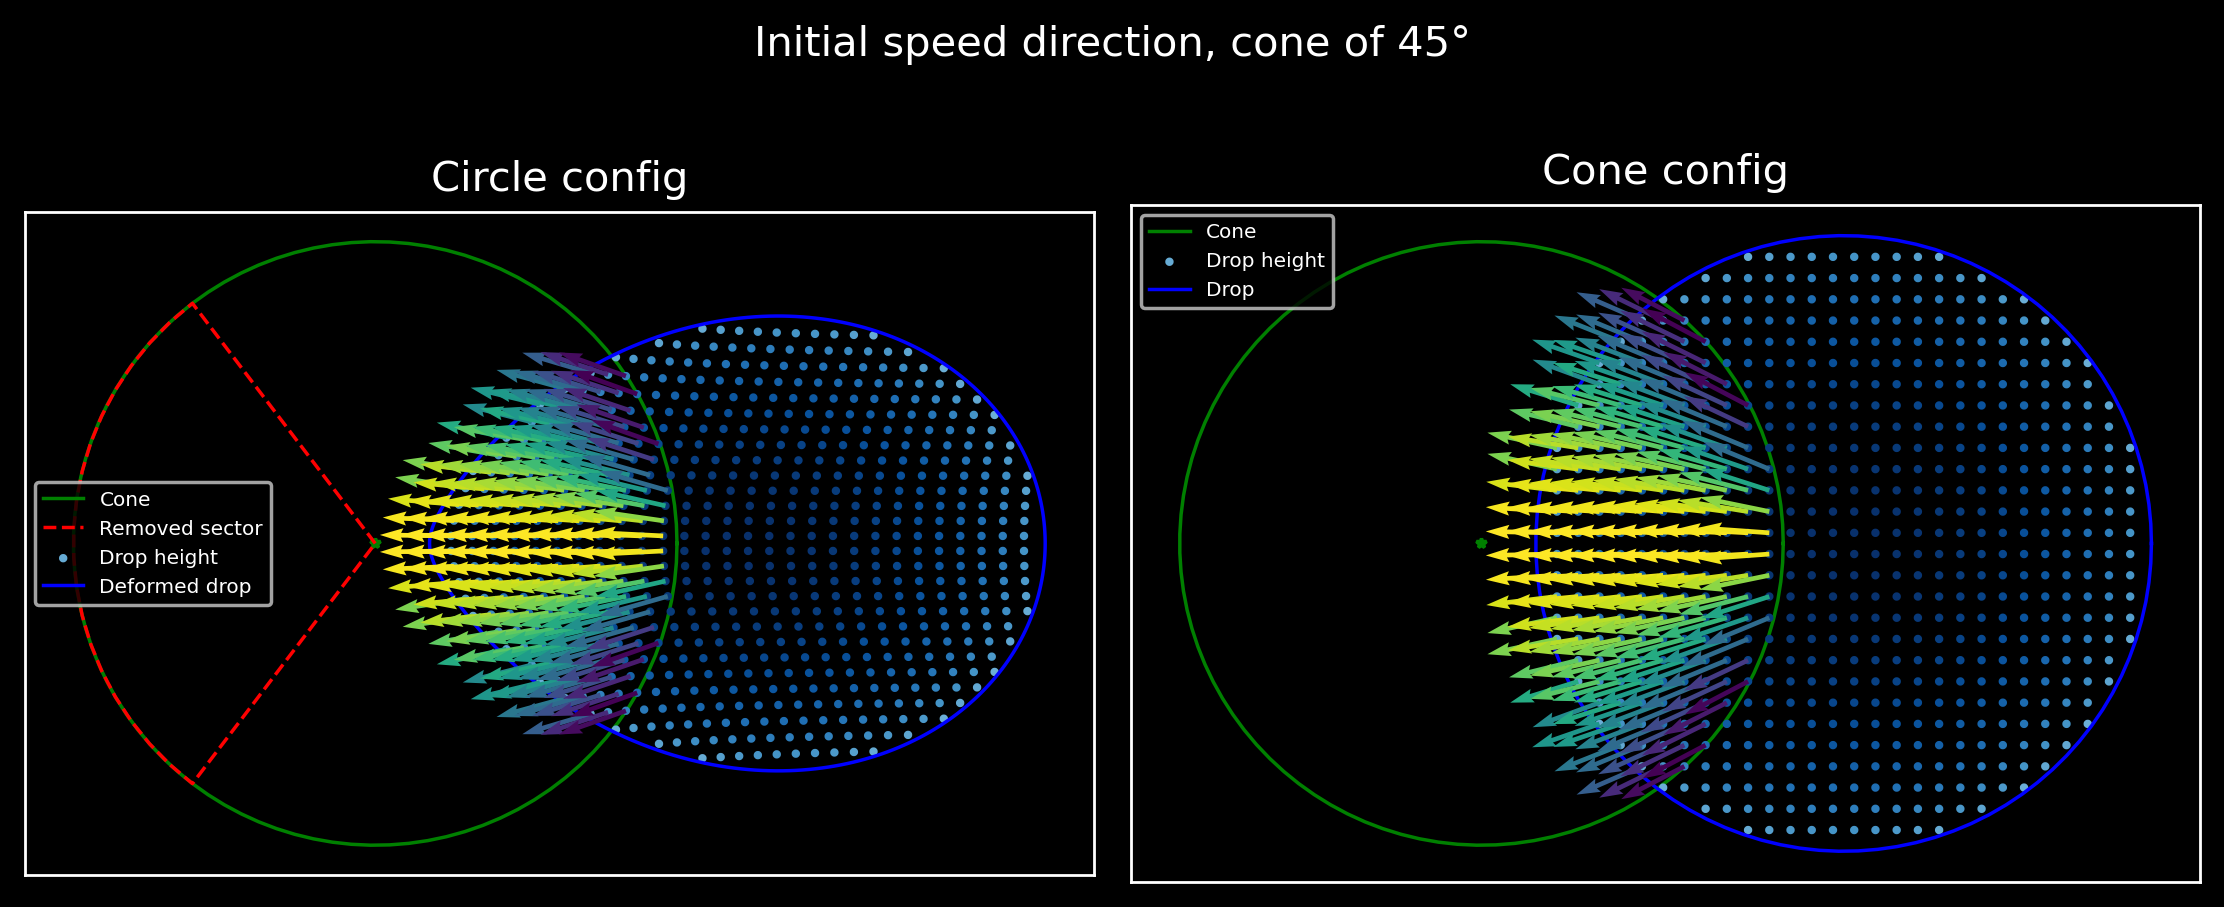

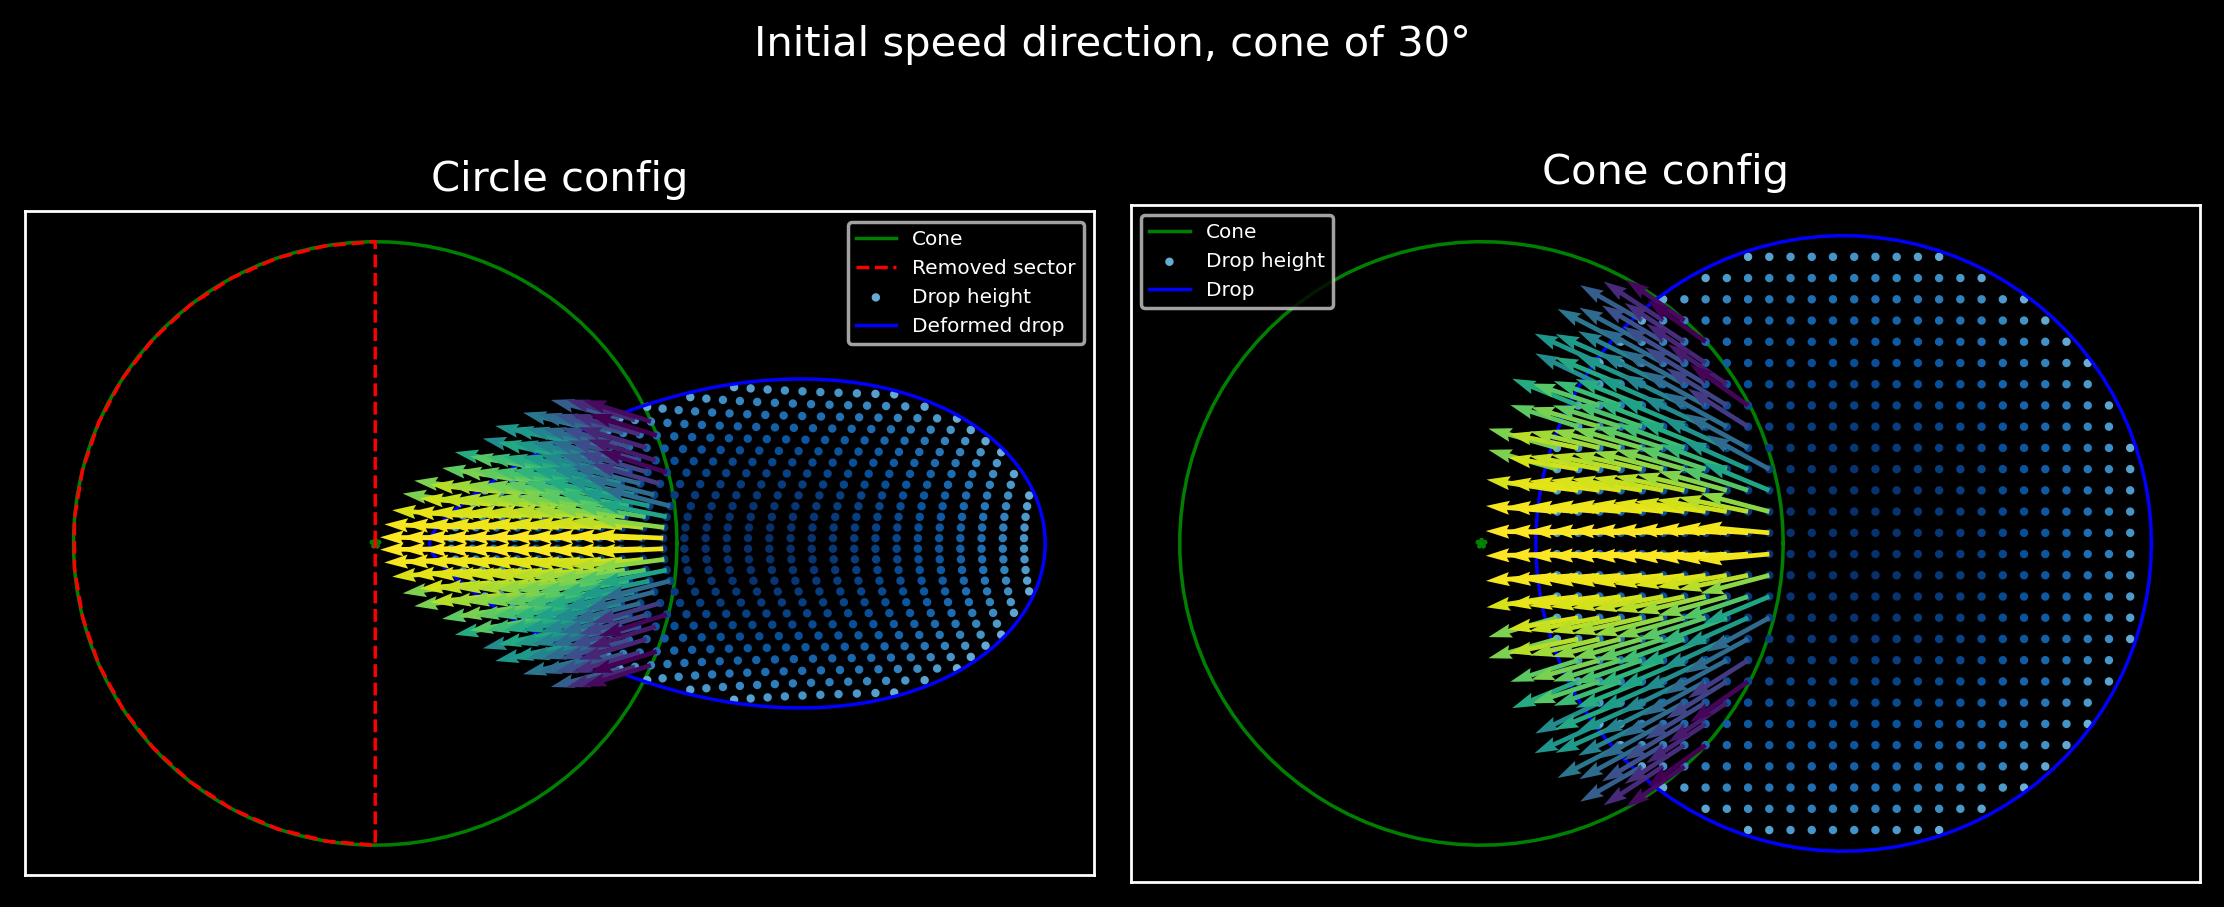

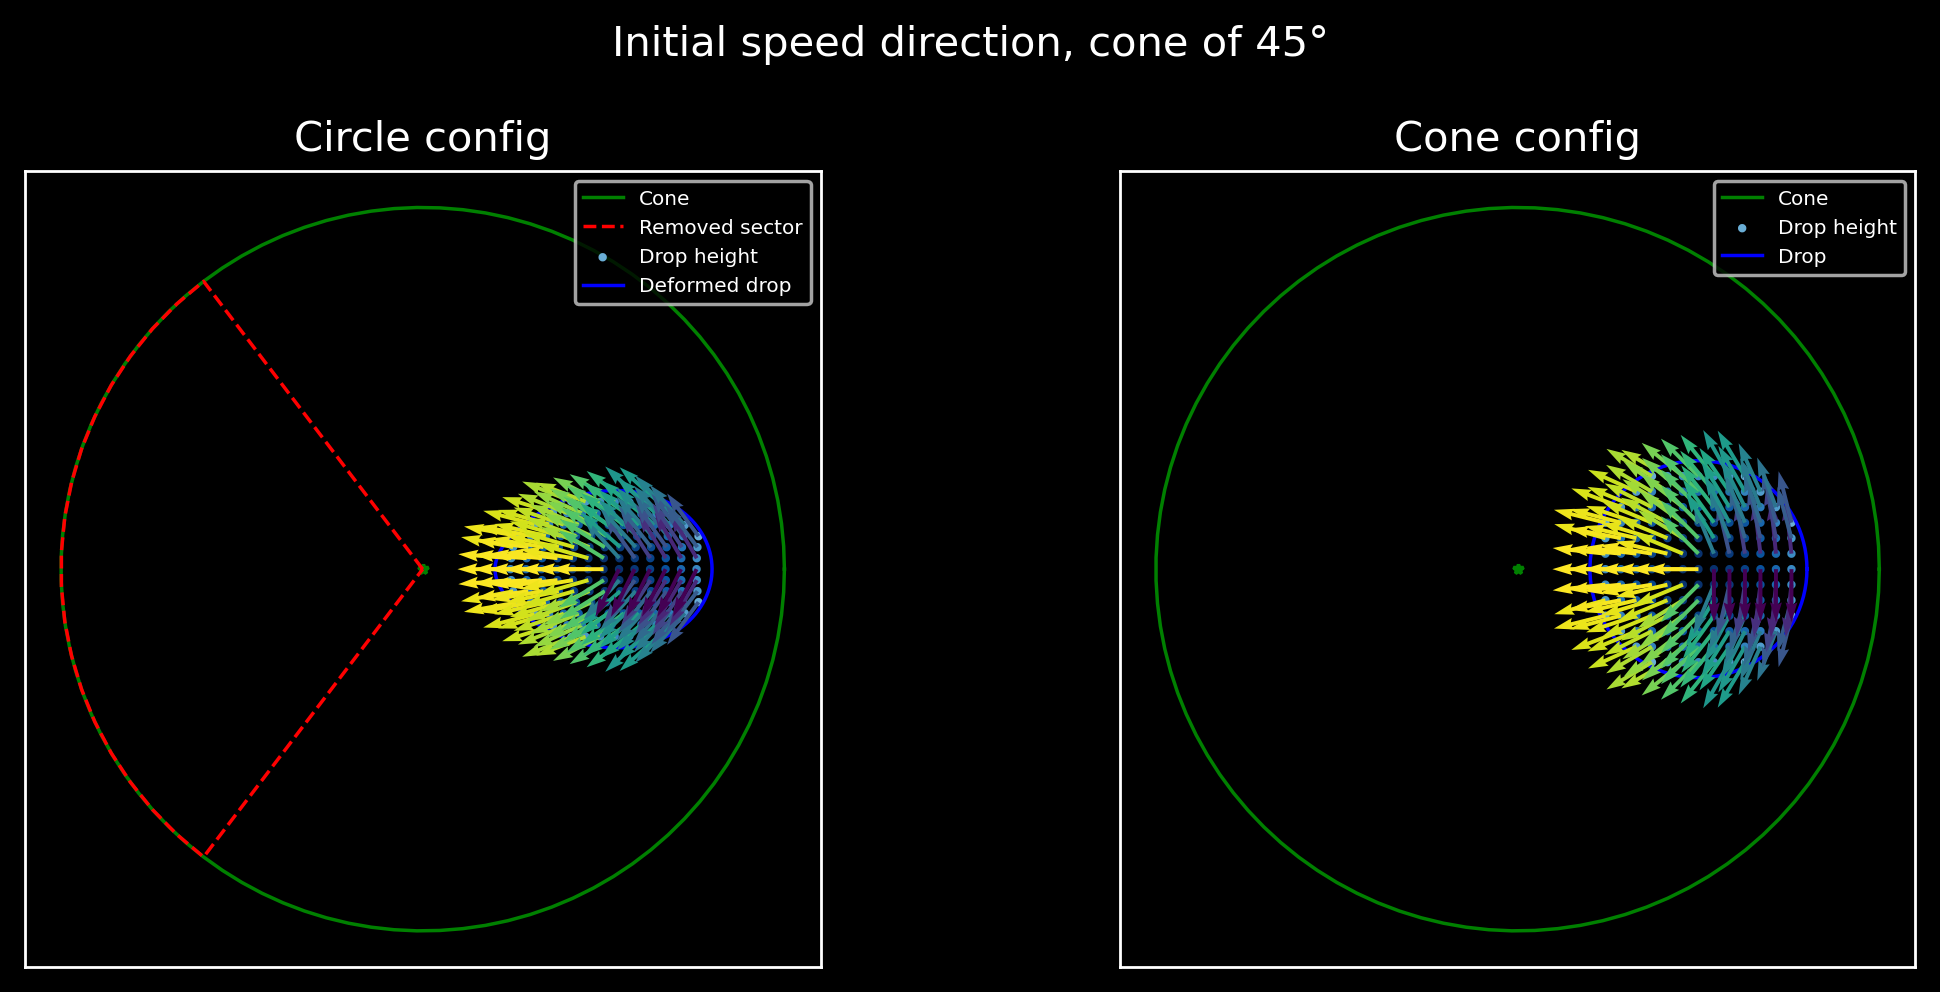

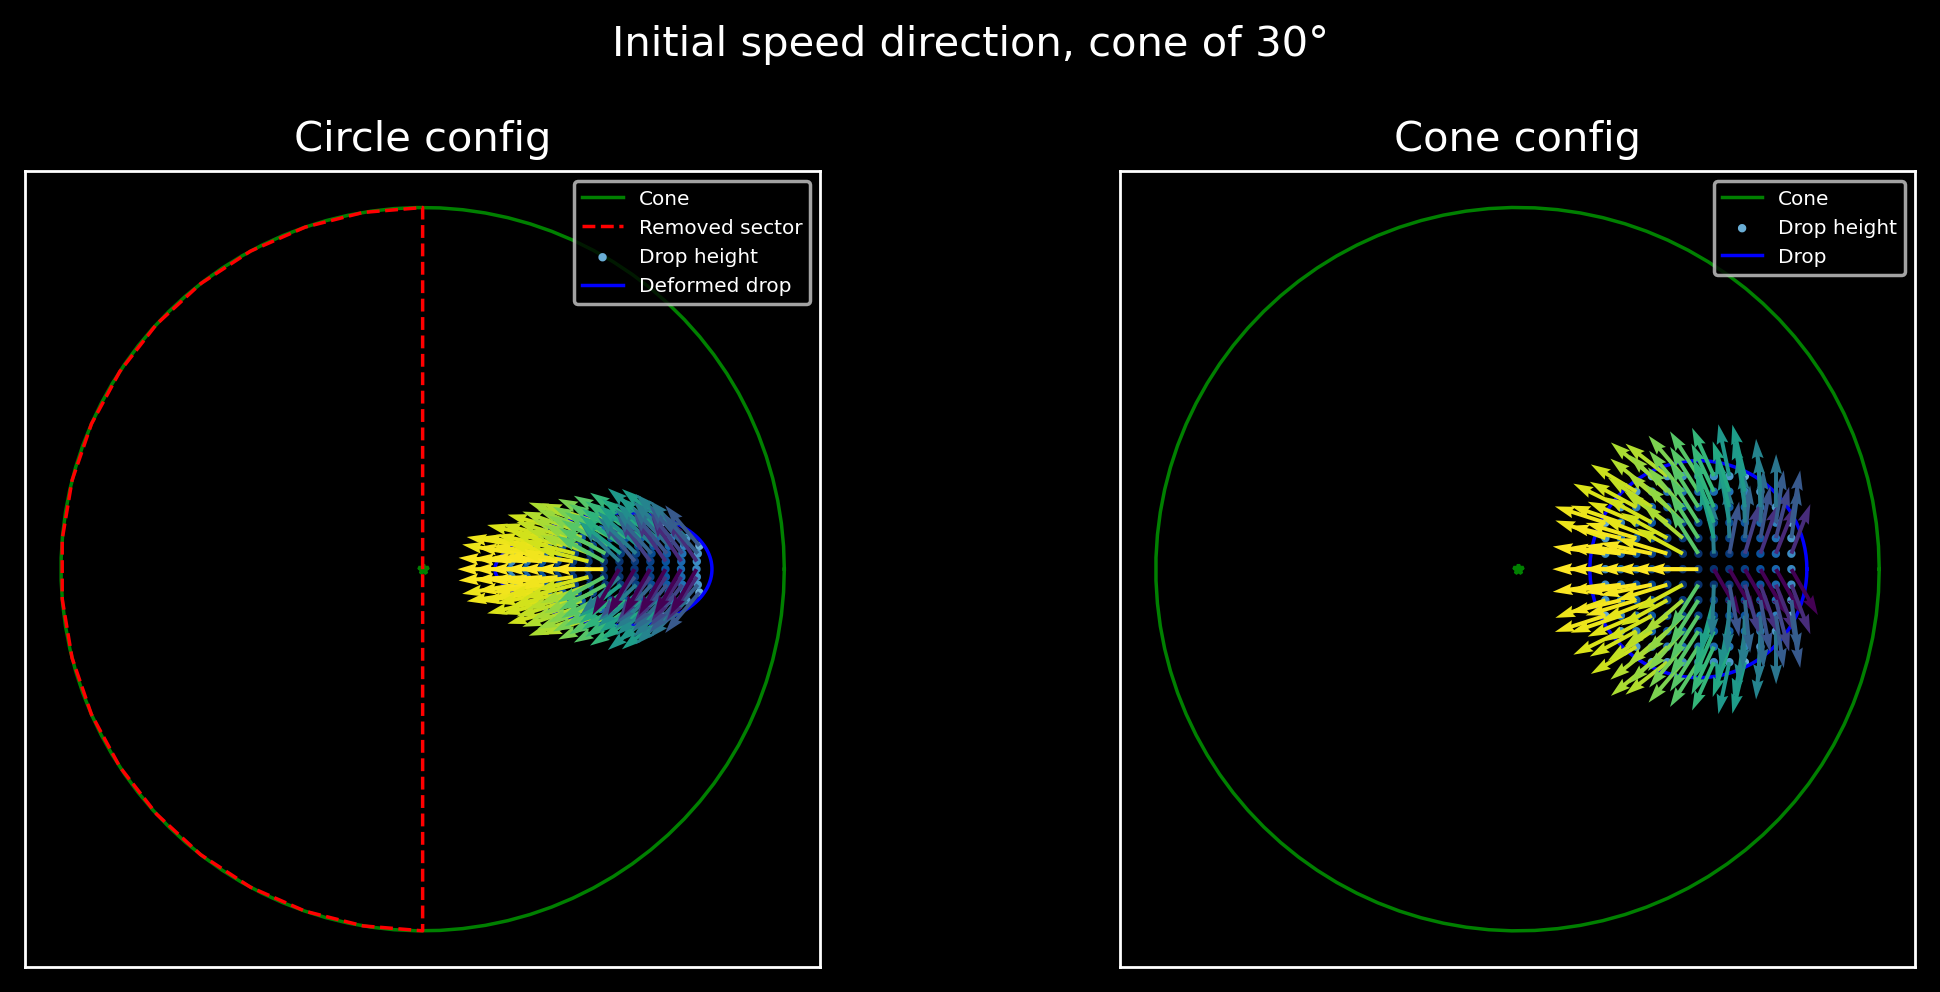

In [34]:
# C30.draw(nolabels=True,drop=D1,dropview = 'full',title='30° cone + D1')
# C30.draw(nolabels=True,drop=D2,dropview = 'impact', title='30° cone + D2')

# C45.draw(nolabels=True,dropview = 'full',drop=D1,title='45° cone + D1')
I_D1_C45.plot_splash_init(norm=True,title='Initial speed direction, cone of 45°',nolabels=True)
I_D1_C30.plot_splash_init(norm=True,title='Initial speed direction, cone of 30°',nolabels=True)
# I_D2_C45.plot_splash_init(norm=True,title='Initial speed direction, cone of 45°',nolabels=True)


# I_D3_C60.plot_splash_init(norm=True,title='Initial speed direction, cone of 60°',nolabels=True)
# I_D3_C45.plot_splash_init(norm=True,title='Initial speed direction, cone of 45°',nolabels=True)


I_D4_C45.plot_splash_init(norm=True,title='Initial speed direction, cone of 45°',nolabels=True)
I_D4_C30.plot_splash_init(norm=True,title='Initial speed direction, cone of 30°',nolabels=True)
# C45.draw(nolabels=True,drop=D2,title='45° cone + D2')

# C60.draw(nolabels=True,drop=D1,title='60° cone + D1')
# C60.draw(nolabels=True,drop=D2,title='60° cone + D2')

### Phase diagram tests

In [23]:

# def PhaseDiagram(nPts,coneR,Alphas):
    
#     for Alpha in Alphas:
        
#         print('\nAlpha = ' + str(Alpha/(2*np.pi)*360) + '°')
        
        
#         Pts = np.linspace(0,nPts-1,nPts).astype(int)

#         dropX = np.linspace(0,3*coneR,nPts) # Drop center X (in cone configuration)
#         dropR = np.linspace(coneR/2,2*coneR,nPts) # Drop radius (cone config)

#         dropXgrid,dropRgrid = np.meshgrid(dropX,dropR)

#         splashType = np.empty((nPts,nPts))

#         # criterion for splash sorting based on fraction of rop volume impacting the cone, 
#         # impact volume fraction in the jet and geometrical parameters
#         def sortSplash(JVF,DF,coneR,dropR,dropX):

#             splashType = -1 # undefined

#             if JVF>=90: # 90% or more of impacting volume in the jet
#                 splashType = 1 # Jet

#             elif JVF>=70: # 70-95% of impacting volume in the jet
#                 splashType = 2 # Transition SJ

#             elif DF <= 50: # 70% or more of the impacting volume is in the splash
#                 # and maximum 50% of drop volume impacts the cone
#                 splashType = 3 # Bell

#             else:
#                 splashType = 4 # Crown

#             return splashType

#         for i in Pts:
#             for j in Pts:

#                 dx = dropX[i]
#                 dr = dropR[j]

#                 text = 'Computing for : ConeR = ' + str(coneR) + ', dropR = ' + str(dr) + ', Offcent = ' + str(dx)

#                 print(text.ljust(10), end= '\r')

#                 if ((dx/dr)-(coneR/dr))<1:

#                     DF = volFrac([dx],dr,coneR) # volFrac(r,Rd,Rc)
#                     JVF = JetVolFrac3D(coneR,Alpha,dr,[dx],100) # JetVolFrac3D(coneR,Alpha,dropR,Xdrops,nptmesh)

#                     splashType[j,i] = sortSplash(JVF,DF,coneR,dr,dx)

#                 else:
#                     splashType[j,i] = 0 # no impact


#         fig,ax = plt.subplots(dpi=150,figsize = (7,6)) 
#         ax.set_title('Alpha = ' + str(Alpha/(2*np.pi)*360) + '°')
#         sc = ax.scatter(dropXgrid/coneR,dropRgrid/coneR,c=splashType,cmap='jet')
#         ax.set_xlabel('Offcent/ConeRadius')
#         ax.set_ylabel('DropSize/ConeSize')
    
#         cbar = plt.colorbar(sc, ticks = [-1,0,1,2,3,4])
#         cbar.ax.set_yticklabels(['undefined','No impact', 'Jet', 'Transition', 'Bell sheet','Crown sheet']);  # vertically oriented colorbar
#         fig.tight_layout()
            

In [24]:
# nPts = 26
# ### Cone
# coneR = 4 # Cone radius
# Alphas = [pi/6,pi/4,pi/3] # Cone vertical angle

# ### Drop
# dropY = 0 # Drop denter Y (in cone configuration)


# # PhaseDiagram(nPts,coneR,Alphas)
